# Time-series prediction of renewable energy production

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
from scipy.signal import savgol_filter

Using TensorFlow backend.
/home/johannes/.virtualenvs/renewables_notebooks/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# display plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 5.0)
# fix seed to make results reproducible
np.random.seed(7)

In [3]:
data = pd.read_csv('../data/generation_2017.csv').set_index('timestamp')

In [4]:
def split_train_test(ds, ratio=2/3):
    train_length = int(ratio * len(ds))
    return ds[:train_length], ds[train_length:]

def create_datasets(ds, lookback=1):
    """
    Create two datasets for training: X = input, Y = output.
    X is three-dimensional: num_samples, lookback_range, num_features.
    Y is two-dimensional: num_samples, num_features. 
    The lookback argument tells us how many samples to scan back.
    """
    acc_x, acc_y = [], []
    for i in range(len(ds) - lookback):
        acc_x.append(ds[i:i + lookback])
        acc_y.append(ds[i + lookback])
    return np.array(acc_x), np.array(acc_y)


In [5]:
lookback = 5

# select the columns we are interested in to model
model_df = data[['renewables', 'non_renewables']]
dataset = model_df.as_matrix()

# scaling to [0, 1] is essential for LSTM training
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_ds, test_ds = split_train_test(dataset, 9/10)
train_x, train_y = create_datasets(train_ds, lookback)
test_x, test_y = create_datasets(test_ds, lookback)

In [17]:
test_x

array([[[ 0.18695001,  0.91657459],
        [ 0.18557318,  0.92265193],
        [ 0.18246034,  0.93060773],
        [ 0.17767136,  0.93812155],
        [ 0.21053577,  0.94121547]],

       [[ 0.18557318,  0.92265193],
        [ 0.18246034,  0.93060773],
        [ 0.17767136,  0.93812155],
        [ 0.21053577,  0.94121547],
        [ 0.2128704 ,  0.93314917]],

       [[ 0.18246034,  0.93060773],
        [ 0.17767136,  0.93812155],
        [ 0.21053577,  0.94121547],
        [ 0.2128704 ,  0.93314917],
        [ 0.22813529,  0.92618785]],

       ..., 
       [[ 0.79610895,  0.07933702],
        [ 0.80688417,  0.09834254],
        [ 0.81448668,  0.10519337],
        [ 0.71900629,  0.08574586],
        [ 0.65208022,  0.05745856]],

       [[ 0.80688417,  0.09834254],
        [ 0.81448668,  0.10519337],
        [ 0.71900629,  0.08574586],
        [ 0.65208022,  0.05745856],
        [ 0.68093385,  0.05381215]],

       [[ 0.81448668,  0.10519337],
        [ 0.71900629,  0.08574586],
     

In [18]:
test_y

array([[ 0.2128704 ,  0.93314917],
       [ 0.22813529,  0.92618785],
       [ 0.24070638,  0.88044199],
       ..., 
       [ 0.68093385,  0.05381215],
       [ 0.63328345,  0.09027624],
       [ 0.64513619,  0.07657459]])

In [6]:
model = Sequential()
model.add(LSTM(32, input_shape=(lookback, 2)))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(train_x, train_y, epochs=50, batch_size=16, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4480      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 4,546
Trainable params: 4,546
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 4s - loss: 0.0136
Epoch 2/50
 - 3s - loss: 0.0037
Epoch 3/50
 - 3s - loss: 0.0022
Epoch 4/50
 - 3s - loss: 0.0018
Epoch 5/50
 - 3s - loss: 0.0015
Epoch 6/50
 - 3s - loss: 0.0012
Epoch 7/50
 - 3s - loss: 0.0011
Epoch 8/50
 - 3s - loss: 0.0010
Epoch 9/50
 - 3s - loss: 9.8863e-04
Epoch 10/50
 - 3s - loss: 9.7082e-04
Epoch 11/50
 - 3s - loss: 9.2768e-04
Epoch 12/50
 - 3s - loss: 9.0327e-04
Epoch 13/50
 - 3s - loss: 8.7577e-04
Epoch 14/50
 - 3s - loss: 8.8009e-04
Epoch 15/50
 - 3s - loss: 8.5788e-04
Epoch 16/50
 - 3s - lo

In [7]:
train_score = model.evaluate(train_x, train_y, verbose=0)
print(f'Train Score: {train_score:.2} MSE ({math.sqrt(train_score):.2} RMSE)')
test_score = model.evaluate(test_x, test_y, verbose=0)
print(f'Test Score: {test_score:.2} MSE ({math.sqrt(test_score):.2} RMSE)')


Train Score: 0.00076 MSE (0.027 RMSE)
Test Score: 0.001 MSE (0.032 RMSE)


In [14]:
test_x

array([[[ 0.18695001,  0.91657459],
        [ 0.18557318,  0.92265193],
        [ 0.18246034,  0.93060773],
        [ 0.17767136,  0.93812155],
        [ 0.21053577,  0.94121547]],

       [[ 0.18557318,  0.92265193],
        [ 0.18246034,  0.93060773],
        [ 0.17767136,  0.93812155],
        [ 0.21053577,  0.94121547],
        [ 0.2128704 ,  0.93314917]],

       [[ 0.18246034,  0.93060773],
        [ 0.17767136,  0.93812155],
        [ 0.21053577,  0.94121547],
        [ 0.2128704 ,  0.93314917],
        [ 0.22813529,  0.92618785]],

       ..., 
       [[ 0.79610895,  0.07933702],
        [ 0.80688417,  0.09834254],
        [ 0.81448668,  0.10519337],
        [ 0.71900629,  0.08574586],
        [ 0.65208022,  0.05745856]],

       [[ 0.80688417,  0.09834254],
        [ 0.81448668,  0.10519337],
        [ 0.71900629,  0.08574586],
        [ 0.65208022,  0.05745856],
        [ 0.68093385,  0.05381215]],

       [[ 0.81448668,  0.10519337],
        [ 0.71900629,  0.08574586],
     

In [26]:
real = scaler.inverse_transform(test_y) 

In [31]:
real_ratio = real[:,0:1] / (real[:,0:1] + real[:,1:2])

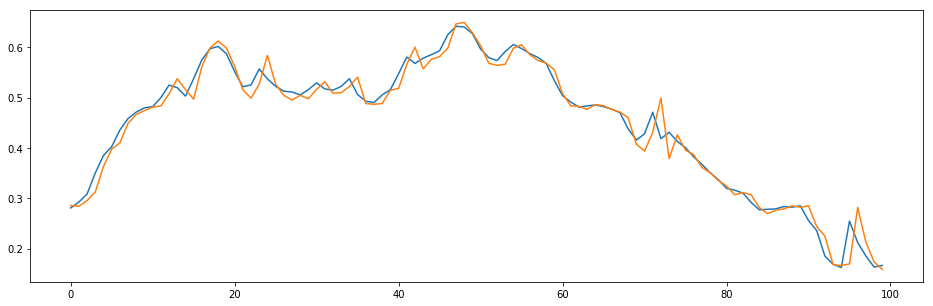

In [36]:
test_predict = model.predict(test_x)
test_predict_mw = scaler.inverse_transform(test_predict)
test_predict_ratio = [renewables / (renewables + non_renewables) for renewables, non_renewables in test_predict_mw]

plt.plot(real_ratio[:100])
plt.plot(test_predict_ratio[:100])
plt.show()

Mental notes:

The test set is 1/10 of the complete data set, ie 720 data points. `test_x` represents the prediction inputs for the test set: `test_x[0]` is a vector of the 5 (because `lookback=5` above) first elements of the test set, and `test_y[0]` is the sixth element, the one which is to be predicted.

Problem:

The LSTM predicts too heavily based on previous value. Need more inputs.



In [22]:
def extend_prediction(model, x, t=1):
    """Returns X suitable for predicting t+1"""
    rows, lookback, _ = x.shape
    assert t < lookback, "Resulting X must retain at least one non-predicted value"
    x_t = x.copy()
    roll_one = lambda arr: np.roll(arr, -1, axis=1)
    for i in range(1, t + 1):
        p = model.predict(x_t)
        x_t = roll_one(x_t)
        for row in range(rows):
            x_t[row, 2] = p[row]
    return model.predict(x_t)

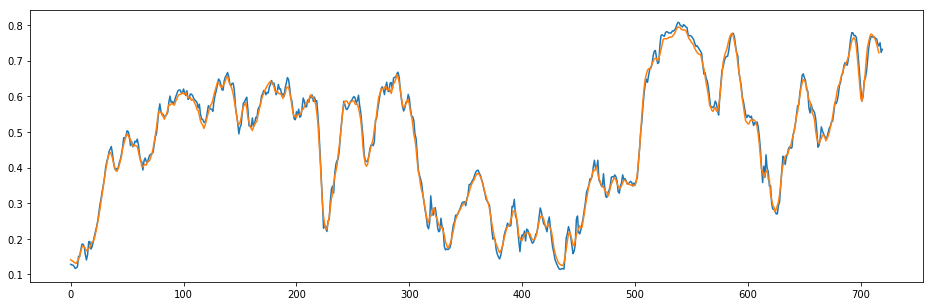

In [23]:
test_predict_t3 = extend_prediction(model, test_x, t = 2)
test_predict_t3_mw = scaler.inverse_transform(test_predict_t3)
test_predict_t3_ratio = [renewables / (renewables + non_renewables) for renewables, non_renewables in test_predict_t3_mw]

plt.plot(real['ratio'])
plt.plot(savgol_filter(test_predict_t3_ratio[-717:], lookback, 1))
plt.show()

* with a lookback of 5, t+3 prediction is still possible
* filter reduces jitter

In [29]:
model.save('model_lstm_32.h5')

### References

* https://keras.io/getting-started/sequential-model-guide/
* https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
